In [ ]:
!pip install wandb onnx -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dest_images_dir = '/content/drive/MyDrive/30_images_masks/images'
dest_masks_dir = '/content/drive/MyDrive/30_images_masks/masks'
c1, c2 = 0, 0
for c in os.listdir(dest_images_dir):
  c1+=1
for c in os.listdir(dest_masks_dir):
  c2+=1
print(c1, c2)

2094 2094


In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
folder_path = "/content/drive/MyDrive/IDD20K_II"
folders = ['mask_archive', 'image_archive']
for folder in folders:
    folder_files = os.listdir(os.path.join(folder_path, folder))
    print(f"The folder '{folder}' has {len(folder_files)} files.")

The folder 'mask_archive' has 6982 files.
The folder 'image_archive' has 6982 files.


In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import random

class_labels = {
    'mask_archive': 0,
    'image_archive': 1
}

class CustomDataset(Dataset):
    image_mask_paths = []

    def __init__(self, img_dir, transform=None, sample_percentage=0.3):
        self.img_dir = img_dir
        self.transform = transform
        self.sample_percentage = 0.3
        self.classes = os.listdir(img_dir)
        print("Classes found:", self.classes)
        self.img_paths = []
        self.mask_paths = {}

        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            img_names = [img_name for img_name in os.listdir(class_dir) if img_name.startswith('image_')]
            random.shuffle(img_names)
            num_images_to_select = int(len(img_names) * sample_percentage)
            selected_img_names = img_names[:num_images_to_select]
            for img_name in selected_img_names:
                img_path = os.path.join(class_dir, img_name)
                self.img_paths.append(img_path)
                image_number = int(img_name.split('_')[1].split('.')[0])
                mask_name = f'mask_{image_number}.jpg'
                mask_path = os.path.join(img_dir, 'mask_archive', mask_name)
                self.mask_paths[img_name] = mask_path
                self.image_mask_paths.append((img_path, mask_path))

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = class_labels['image_archive']
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)

        img_name = os.path.basename(img_path)
        mask_path = self.mask_paths[img_name]
        mask = Image.open(mask_path)
        if self.transform:
            mask = self.transform(mask)

        return img, mask, label

    def __len__(self):
        return len(self.img_paths)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset('/content/drive/MyDrive/IDD20K_II', transform=transform)

image_mask_paths = CustomDataset.image_mask_paths
print(image_mask_paths)


Classes found: ['image_archive', 'mask_archive']
[('/content/drive/MyDrive/IDD20K_II/image_archive/image_1065.jpg', '/content/drive/MyDrive/IDD20K_II/mask_archive/mask_1065.jpg'), ('/content/drive/MyDrive/IDD20K_II/image_archive/image_1176.jpg', '/content/drive/MyDrive/IDD20K_II/mask_archive/mask_1176.jpg'), ('/content/drive/MyDrive/IDD20K_II/image_archive/image_4051.jpg', '/content/drive/MyDrive/IDD20K_II/mask_archive/mask_4051.jpg'), ('/content/drive/MyDrive/IDD20K_II/image_archive/image_1056.jpg', '/content/drive/MyDrive/IDD20K_II/mask_archive/mask_1056.jpg'), ('/content/drive/MyDrive/IDD20K_II/image_archive/image_5348.jpg', '/content/drive/MyDrive/IDD20K_II/mask_archive/mask_5348.jpg'), ('/content/drive/MyDrive/IDD20K_II/image_archive/image_2564.jpg', '/content/drive/MyDrive/IDD20K_II/mask_archive/mask_2564.jpg'), ('/content/drive/MyDrive/IDD20K_II/image_archive/image_3297.jpg', '/content/drive/MyDrive/IDD20K_II/mask_archive/mask_3297.jpg'), ('/content/drive/MyDrive/IDD20K_II/image

In [ ]:
import shutil

dest_images_dir = '/content/drive/MyDrive/30_images_masks/images'
dest_masks_dir = '/content/drive/MyDrive/30_images_masks/masks'

for img_path, mask_path in image_mask_paths:
  img_name = os.path.basename(img_path)
  mask_name = os.path.basename(mask_path)
  shutil.copy(img_path, os.path.join(dest_images_dir, img_name))
  shutil.copy(mask_path, os.path.join(dest_masks_dir, mask_name))

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_folder = "/content/drive/MyDrive/IDD20K_II/image_archive/"
mask_folder = "/content/drive/MyDrive/IDD20K_II/mask_archive/"


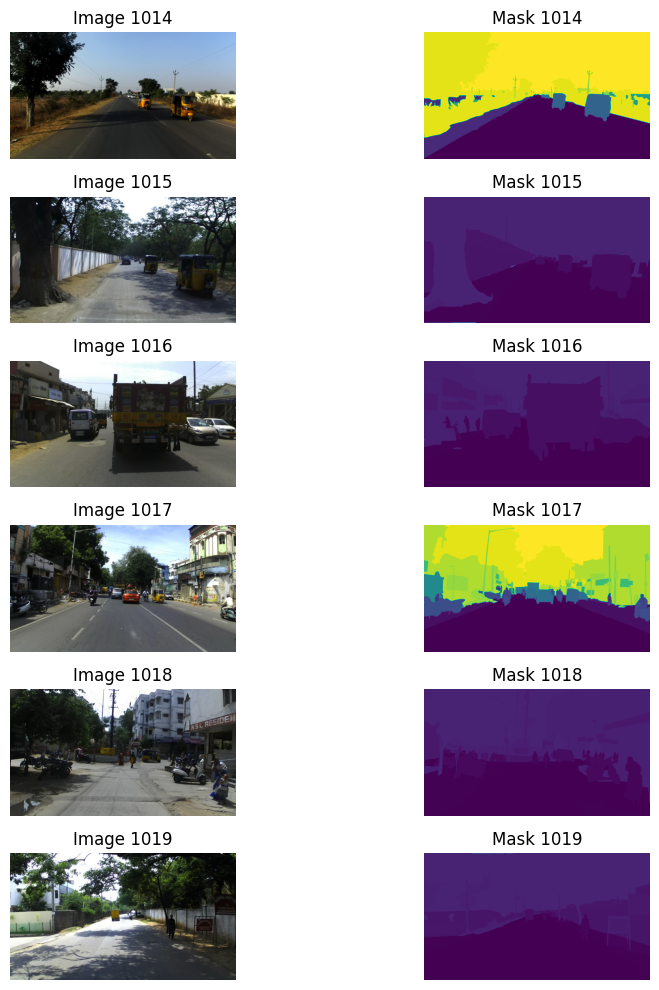

In [ ]:
class_colors = {
    0: [0, 0, 0],
    1: [255, 0, 0],
    2: [0, 255, 0],
}
def display_samples(start_idx, end_idx):
    num_rows = end_idx - start_idx + 1
    num_columns = 2
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 10))

    for i in range(start_idx, end_idx + 1):
        sample = f'image_{i}.jpg'
        sample_mask = f'mask_{i}.jpg'
        image_path = os.path.join(image_folder, sample)
        mask_path = os.path.join(mask_folder, sample_mask)

        image = Image.open(image_path)
        mask = Image.open(mask_path)
        ind = i - start_idx
        axes[ind, 0].imshow(image)
        axes[ind, 0].set_title(f'Image {i}')
        axes[ind, 0].axis('off')

        axes[ind, 1].imshow(mask)
        axes[ind, 1].set_title(f'Mask {i}')
        axes[ind, 1].axis('off')

    plt.tight_layout()
    plt.show()

display_samples(start_idx=1014, end_idx=1019)

In [ ]:
pip install torch torchvision

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

don't use this

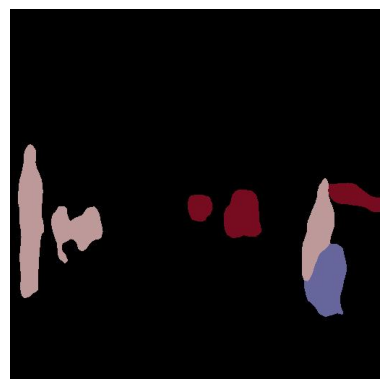

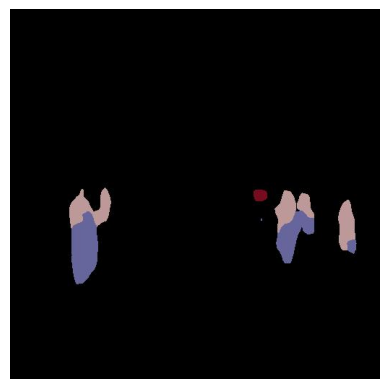

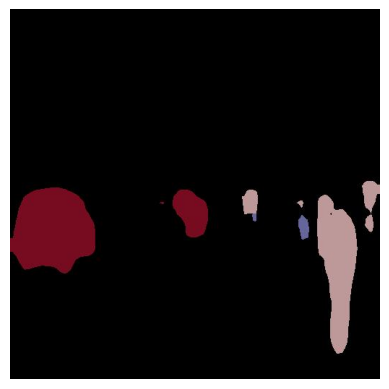

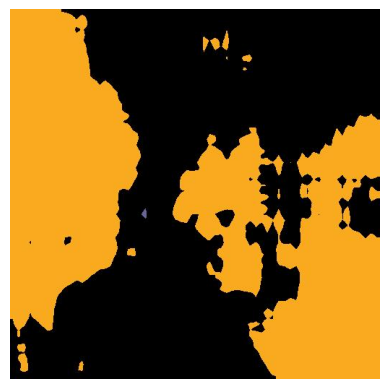

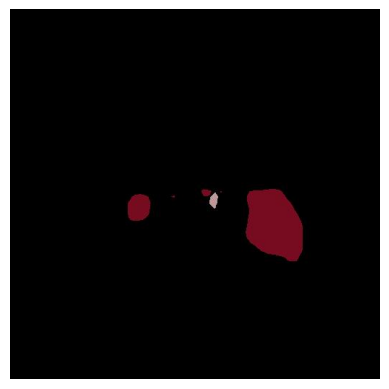

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
output_dir = "/content/drive/MyDrive/output_mask"

files = os.listdir(output_dir)
i=0
for file in files:
    if(i==5):
      break
    i+=1
    if file.endswith(".jpg"):
        file_path = os.path.join(output_dir, file)
        image = Image.open(file_path)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

Today final inference


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

relevant_classes = ['Road', 'Sidewalk', 'Person', 'Rider', 'Motorbike', 'Bicycle', 'Car', 'Truck', 'Bus',
                    'Train', 'Wall', 'Fence', 'Traffic Sign', 'Traffic Light', 'Pole', 'Building',
                    'Vegetation', 'Sky']

cityscapes_class_ids = {
    'Road': 0+1, 'Sidewalk': 2, 'Person':4, 'Rider': 5, 'Motorbike':6, 'Bicycle': 7,
    'Car': 9, 'Truck': 10, 'Bus': 11, 'Train': 12, 'Wall': 14, 'Fence': 15,
    'Traffic Sign': 18, 'Traffic Light': 19, 'Pole': 20, 'Building': 22,
    'Vegetation': 24, 'Sky': 25
}

class_colors = {
    1: [128, 64, 128],
    2: [244, 35, 232],
    4: [220, 20, 60],
    5: [0, 0, 230],
    6: [0, 0, 142],
    7: [119, 11, 32],
    9: [0, 0, 230],
    10: [0, 0, 70],
    11: [0, 0, 70],
    12: [0, 0, 70],
    14: [102, 102, 156],
    15: [190, 153, 153],
    18: [220, 220, 0],
    19: [250, 170, 30],
    20: [153, 153, 153],
    22: [70, 70, 70],
    24: [107, 142, 35],
    25: [70, 130, 180],
}

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def inference_image(image, model, transform, device):
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)
        output = model(image)['out'][0]
        output = torch.argmax(output, dim=0).cpu().numpy()
    return output

def colorize_mask(mask, class_colors):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        colored_mask[mask == class_id] = color
    return colored_mask


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()
model.to(device)


images_dir = "/content/drive/MyDrive/30_images_masks/images"
masks_dir = "/content/drive/MyDrive/30_images_masks/masks"
output_dir = "/content/drive/MyDrive/output_mask"


os.makedirs(output_dir, exist_ok=True)


image_paths = sorted(os.listdir(images_dir))
mask_paths = sorted(os.listdir(masks_dir))
for image_name, mask_name in tqdm(zip(image_paths, mask_paths), desc="Performing inference"):
    image_path = os.path.join(images_dir, image_name)
    mask_path = os.path.join(masks_dir, mask_name)

    image = Image.open(image_path).convert("RGB")

    output = inference_image(image, model, transform, device)

    relevant_class_ids = [cityscapes_class_ids[class_name] for class_name in relevant_classes]
    filtered_output = np.where(np.isin(output, relevant_class_ids), output, 0)

    colored_output = colorize_mask(filtered_output, class_colors)

    output_name = mask_name.split('.')[0] + '_colored.jpg'
    output_path = os.path.join(output_dir, output_name)
    colorized_segmentation_mask = Image.fromarray(colored_output)
    colorized_segmentation_mask.save(output_path, "JPEG")

print("Inference completed.")


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:03<00:00, 43.5MB/s]
Performing inference: 2094it [

Inference completed.


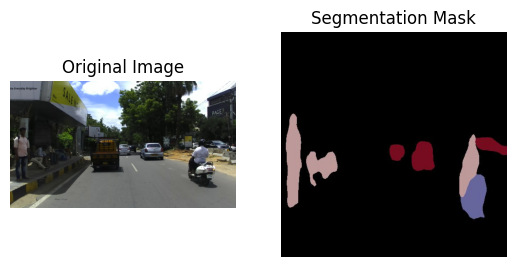

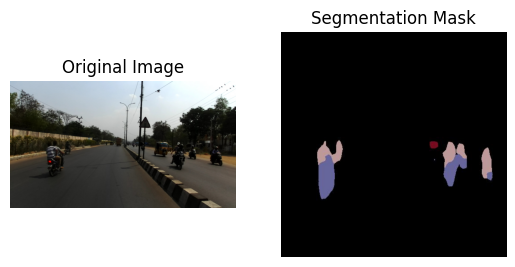

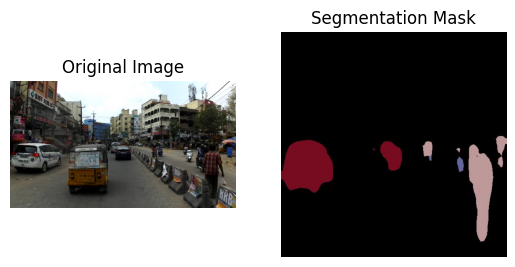

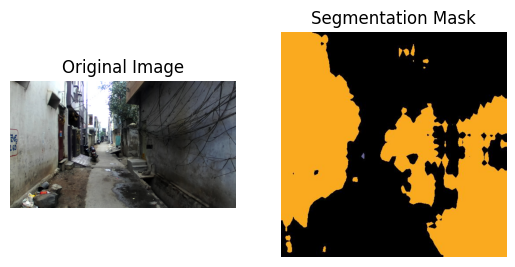

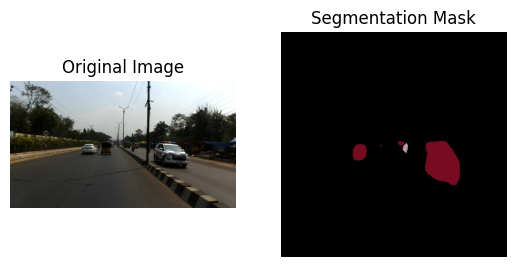

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_dir = "/content/drive/MyDrive/30_images_masks/images/"
output_dir = "/content/drive/MyDrive/output_mask"

output_files = sorted(os.listdir(output_dir))
i=0
for output_file in output_files:
    if(i==5):
      break
    i+=1
    if output_file.endswith(".jpg"):
        image_file = output_file.split('.')[0] + '.jpg'
        image_file = 'image_'+image_file.split('_')[1]
        image_path = os.path.join(image_dir, image_file)
        output_path = os.path.join(output_dir, output_file)

        if os.path.exists(image_path):
            try:
                image = Image.open(image_path)
                plt.subplot(1, 2, 1)
                plt.imshow(image)
                plt.title("Original Image")
                plt.axis("off")

                mask = Image.open(output_path)
                plt.subplot(1, 2, 2)
                plt.imshow(mask)
                plt.title("Segmentation Mask")
                plt.axis("off")

                plt.show()
            except Exception as e:
                print(f"Error displaying images: {e}")
        else:
            print(f"Image file not found: {image_path}")


In [ ]:
output_dir = "/content/drive/MyDrive/output_mask"

# Iterate over each file in the directory
for filename in os.listdir(output_dir):
    # Check if the file name ends with "_colored.jpg"
    if filename.endswith("_colored.jpg"):
        # Construct the new file name by removing "_colored"
        new_filename = filename.replace("_colored.jpg", ".jpg")
        # Rename the file
        os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, new_filename))
        print(f"Renamed {filename} to {new_filename}")

print("File renaming completed.")

Renamed mask_1_colored.jpg to mask_1.jpg
Renamed mask_1003_colored.jpg to mask_1003.jpg
Renamed mask_1005_colored.jpg to mask_1005.jpg
Renamed mask_1007_colored.jpg to mask_1007.jpg
Renamed mask_1012_colored.jpg to mask_1012.jpg
Renamed mask_1017_colored.jpg to mask_1017.jpg
Renamed mask_1019_colored.jpg to mask_1019.jpg
Renamed mask_1023_colored.jpg to mask_1023.jpg
Renamed mask_1032_colored.jpg to mask_1032.jpg
Renamed mask_1040_colored.jpg to mask_1040.jpg
Renamed mask_1042_colored.jpg to mask_1042.jpg
Renamed mask_1044_colored.jpg to mask_1044.jpg
Renamed mask_1047_colored.jpg to mask_1047.jpg
Renamed mask_1049_colored.jpg to mask_1049.jpg
Renamed mask_1056_colored.jpg to mask_1056.jpg
Renamed mask_1062_colored.jpg to mask_1062.jpg
Renamed mask_1065_colored.jpg to mask_1065.jpg
Renamed mask_1071_colored.jpg to mask_1071.jpg
Renamed mask_1074_colored.jpg to mask_1074.jpg
Renamed mask_1075_colored.jpg to mask_1075.jpg
Renamed mask_1076_colored.jpg to mask_1076.jpg
Renamed mask_1079_c

In [ ]:
masks_dir = "/content/drive/MyDrive/30_images_masks/masks"
output_dir = "/content/drive/MyDrive/output_mask"

masks_files = set(os.listdir(masks_dir))
output_files = set(os.listdir(output_dir))

unique_masks_files = masks_files - output_files
unique_output_files = output_files - masks_files

unique_masks_files = list(unique_masks_files)
unique_output_files = list(unique_output_files)

# for file_name in unique_output_files:
#     file_path = os.path.join(output_dir, file_name)
#     os.remove(file_path)

print("Files unique to masks directory:", unique_masks_files)
print("Files unique to output directory:", unique_output_files)

Files unique to masks directory: []
Files unique to output directory: []


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
masks_dir = "/content/drive/MyDrive/30_images_masks/masks"
ground_truth_masks = [tf.convert_to_tensor(np.array(Image.open(os.path.join(masks_dir, mask_name)))) for mask_name in sorted(os.listdir(masks_dir))]

output_dir = "/content/drive/MyDrive/output_mask"
generated_masks = [tf.convert_to_tensor(np.array(Image.open(os.path.join(output_dir, mask_name)))) for mask_name in sorted(os.listdir(output_dir))]

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

relevant_classes = ['Road', 'Sidewalk', 'Person', 'Rider', 'Motorbike', 'Bicycle', 'Car', 'Truck', 'Bus',
                    'Train', 'Wall', 'Fence', 'Traffic Sign', 'Traffic Light', 'Pole', 'Building',
                    'Vegetation', 'Sky']
cityscapes_class_ids = {
    'Road': 0+1, 'Sidewalk': 2, 'Person':4, 'Rider': 5, 'Motorbike':6, 'Bicycle': 7,
    'Car': 9, 'Truck': 10, 'Bus': 11, 'Train': 12, 'Wall': 14, 'Fence': 15,
    'Traffic Sign': 18, 'Traffic Light': 19, 'Pole': 20, 'Building': 22,
    'Vegetation': 24, 'Sky': 25
}

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def inference_image(image, model, transform, device, gt_mask, metrics):
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)
        output = model(image)['out'][0]
        output = torch.argmax(output, dim=0).cpu().numpy()

        if gt_mask.shape != output.shape:
            raise ValueError("Shapes of ground truth mask and predicted output are not consistent.")

        metrics['pixel_accuracy'].append(accuracy_score(gt_mask.flatten(), output.flatten()))
        metrics['precision'].append(precision_score(gt_mask.flatten(), output.flatten(), average='weighted'))
        metrics['recall'].append(recall_score(gt_mask.flatten(), output.flatten(), average='weighted'))
        metrics['f1_score'].append(f1_score(gt_mask.flatten(), output.flatten(), average='weighted'))
        metrics['conf_matrix'] += confusion_matrix(gt_mask.flatten(), output.flatten(), labels=list(range(len(relevant_classes))))

    return output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()
model.to(device)

images_dir = "/content/drive/MyDrive/30_images_masks/images"
masks_dir = "/content/drive/MyDrive/30_images_masks/masks"
output_dir = "/content/drive/MyDrive/output_mask"

os.makedirs(output_dir, exist_ok=True)

metrics = {
    'pixel_accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'conf_matrix': np.zeros((len(relevant_classes), len(relevant_classes)), dtype=np.int64)
}

image_paths = sorted(os.listdir(images_dir))
mask_paths = sorted(os.listdir(masks_dir))
for image_name, mask_name in tqdm(zip(image_paths, mask_paths), desc="Performing inference and calculating metrics"):
    image_path = os.path.join(images_dir, image_name)
    mask_path = os.path.join(masks_dir, mask_name)

    image = Image.open(image_path).convert("RGB").resize((512, 512))
    gt_mask = np.array(Image.open(mask_path).convert("L").resize((512, 512)))

    output = inference_image(image, model, transform, device, gt_mask, metrics)
    output_name = mask_name.split('.')[0] + '.jpg'
    output_path = os.path.join(output_dir, output_name)
    segmentation_mask = Image.fromarray(output.astype(np.uint8))
    segmentation_mask.save(output_path, "JPEG")

conf_matrix = metrics['conf_matrix']
IoUs = np.zeros(len(relevant_classes))
for i in range(len(relevant_classes)):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp
    IoUs[i] = tp / (tp + fp + fn)

mAP = np.mean(IoUs)
IoU_by_class = {class_name: IoU for class_name, IoU in zip(relevant_classes, IoUs)}

print("Pixel-wise accuracy:", np.mean(metrics['pixel_accuracy']))
print("Mean Average Precision (mAP):", mAP)
print("Intersection over Union (IoU) by class:", IoU_by_class)
print("Precision:", np.mean(metrics['precision']))
print("Recall:", np.mean(metrics['recall']))
print("F1 Score:", np.mean(metrics['f1_score']))
print("Confusion Matrix:\n", conf_matrix)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 70.3MB/s]
Performing inference and calcu

Pixel-wise accuracy: 0.265038886521129
Mean Average Precision (mAP): 0.033985938845256844
Intersection over Union (IoU) by class: {'Road': 0.6056089277458108, 'Sidewalk': 0.0, 'Person': 0.0010431336620083573, 'Rider': 1.3428307451367805e-05, 'Motorbike': 0.0, 'Bicycle': 0.0, 'Car': 0.0005187078236879912, 'Truck': 0.002262539753278725, 'Bus': 0.0, 'Train': 4.195170098286729e-05, 'Wall': 3.428718601476183e-05, 'Fence': 0.0, 'Traffic Sign': 3.816947671767947e-06, 'Traffic Light': 2.990439908662764e-06, 'Pole': 0.00040942338568407573, 'Building': 0.0014199467974562534, 'Vegetation': 0.00038774546466758387, 'Sky': 0.0}
Precision: 0.08290315581990039
Recall: 0.265038886521129
F1 Score: 0.12489391345490947
Confusion Matrix:
 [[145433853         0     14495        14         0         0     61377
     175935         0         5      1944         0       213       440
     145785     81285       280         0]
 [ 32053075         0      8171        86         0         0      9811
      37073  

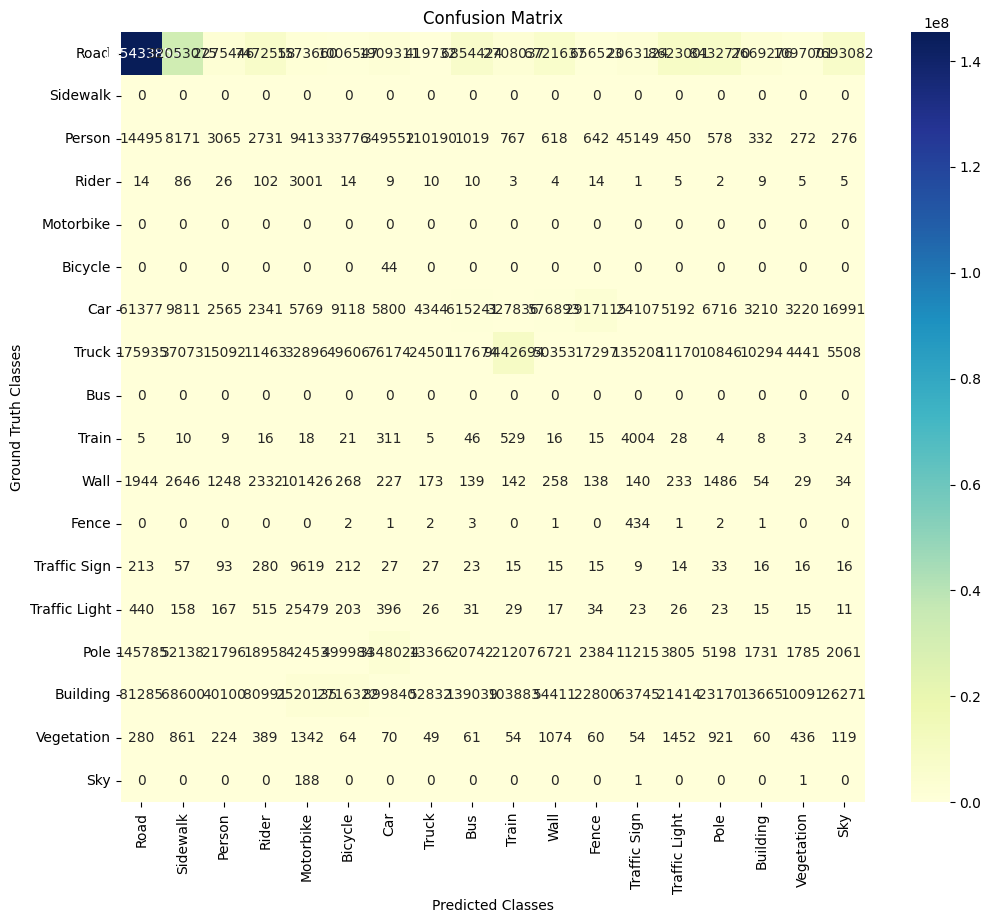

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = np.array(conf_matrix)
relevant_classes = ['Road', 'Sidewalk', 'Person', 'Rider', 'Motorbike', 'Bicycle', 'Car', 'Truck', 'Bus',
                    'Train', 'Wall', 'Fence', 'Traffic Sign', 'Traffic Light', 'Pole', 'Building',
                    'Vegetation', 'Sky']

confusion_matrix = data.T

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=relevant_classes, yticklabels=relevant_classes)
plt.xlabel('Predicted Classes')
plt.ylabel('Ground Truth Classes')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision = np.zeros(len(relevant_classes))
recall = np.zeros(len(relevant_classes))
f1_score = np.zeros(len(relevant_classes))

for i in range(len(relevant_classes)):
    tp = confusion_matrix[i, i]
    fp = np.sum(confusion_matrix[:, i]) - tp
    fn = np.sum(confusion_matrix[i, :]) - tp

    precision = np.zeros(len(relevant_classes))
    recall = np.zeros(len(relevant_classes))
    f1_score = np.zeros(len(relevant_classes))
    c=0
    for i in range(len(relevant_classes)):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        c+=1
        if (tp + fp) > 0:
            precision[i] = tp / (tp + fp)
        else:
            precision[i] = 0

        if (tp + fn) > 0:
            c-=1
            recall[i] = tp / (tp + fn)
        else:
            recall[i] = 0

        if (precision[i] + recall[i]) > 0:
            c+=1
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        else:
            f1_score[i] = 0

for i, class_name in enumerate(relevant_classes):
    print("Class: ", class_name)
    print("Precision: ", precision[i])
    print("Recall: ",recall[i])
    print("F1 Score: ",f1_score[i])
    print("-----------------------")

mean_f1_score = np.mean(f1_score)
print(f"Mean F1 Score: {mean_f1_score:.4f}")

threshold = mean_f1_score
classes_well = []
for i in range(len(relevant_classes)):
    if f1_score[i] >= threshold:
        classes_well.append({"Class": relevant_classes[i], "F1 Score": f1_score[i]})
classes_improve = []
for i in range(len(relevant_classes)):
    if f1_score[i] < threshold:
        classes_improve.append({"Class": relevant_classes[i], "F1 Score": f1_score[i]})

print("Classes where the model performs well: ",classes_well)
print("Classes where improvement is needed: ",classes_improve)

Class:  Road
Precision:  0.996698276852131
Recall:  0.6068263286819379
F1 Score:  0.7543666671012516
-----------------------
Class:  Sidewalk
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
-----------------------
Class:  Person
Precision:  0.0012988218224101642
Recall:  0.005270887503955315
F1 Score:  0.002084093336103058
-----------------------
Class:  Rider
Precision:  1.3433998764072114e-05
Recall:  0.03072289156626506
F1 Score:  2.6856254268696296e-05
-----------------------
Class:  Motorbike
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
-----------------------
Class:  Bicycle
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
-----------------------
Class:  Car
Precision:  0.0008801499775561755
Recall:  0.0012615151318740069
F1 Score:  0.0010368778107433412
-----------------------
Class:  Truck
Precision:  0.0391854869277753
Recall:  0.002395430292157241
F1 Score:  0.004514864446267105
-----------------------
Class:  Bus
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
-----------------------
Clas

<ipython-input-8-6f2792b48cc0>:44: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  indices = np.where(IoU_by_class[class_name] <= 0.5)[0]


No images with IoU <= 0.5 for class: Road
Visualizing images with IoU <= 0.5 for class: Sidewalk


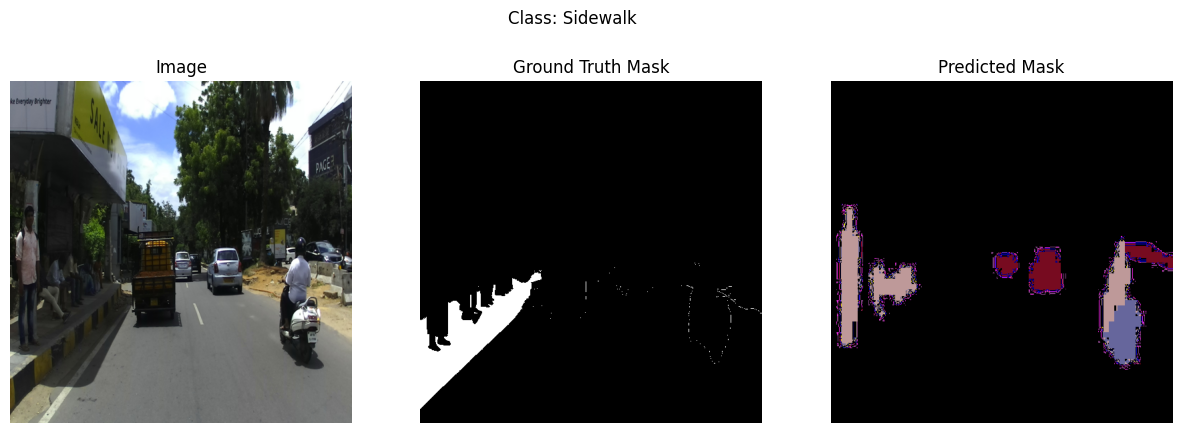

Visualizing images with IoU <= 0.5 for class: Person


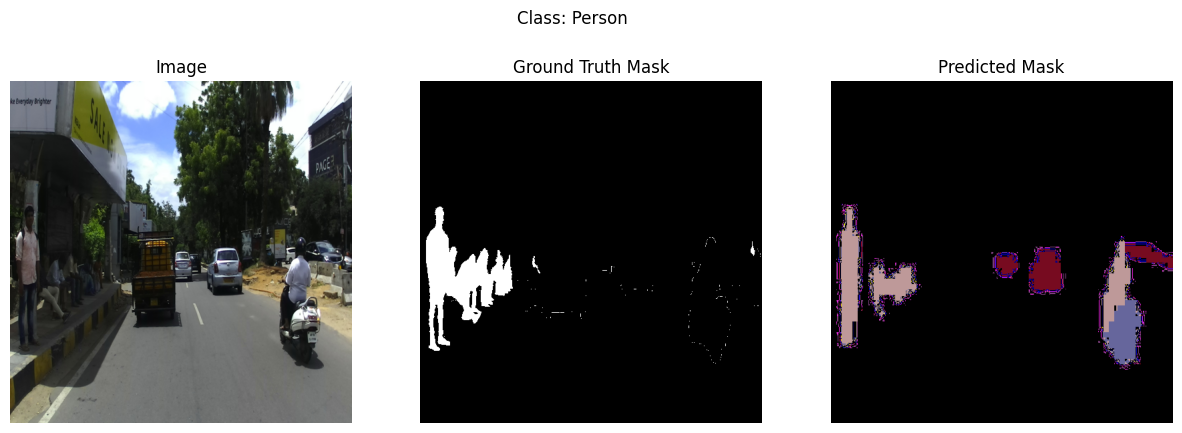

Visualizing images with IoU <= 0.5 for class: Rider


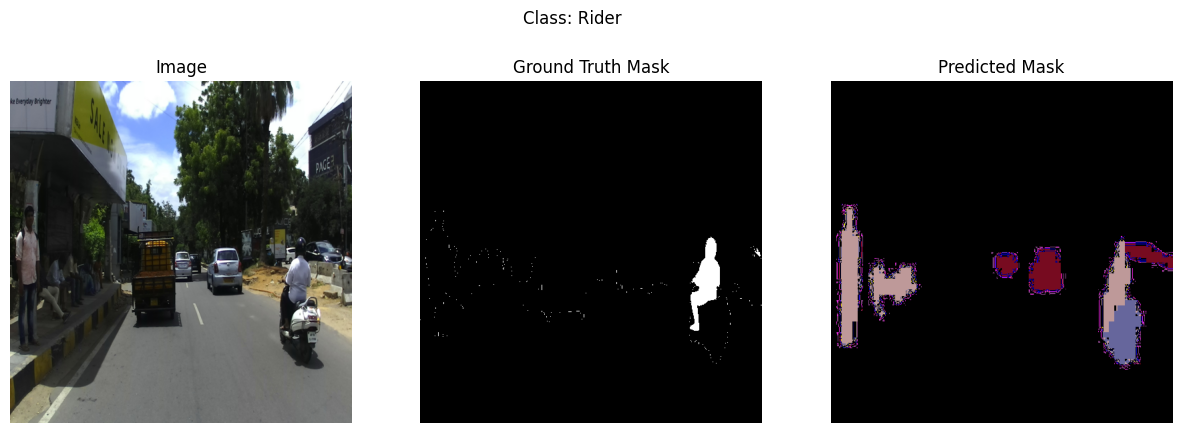

Visualizing images with IoU <= 0.5 for class: Motorbike


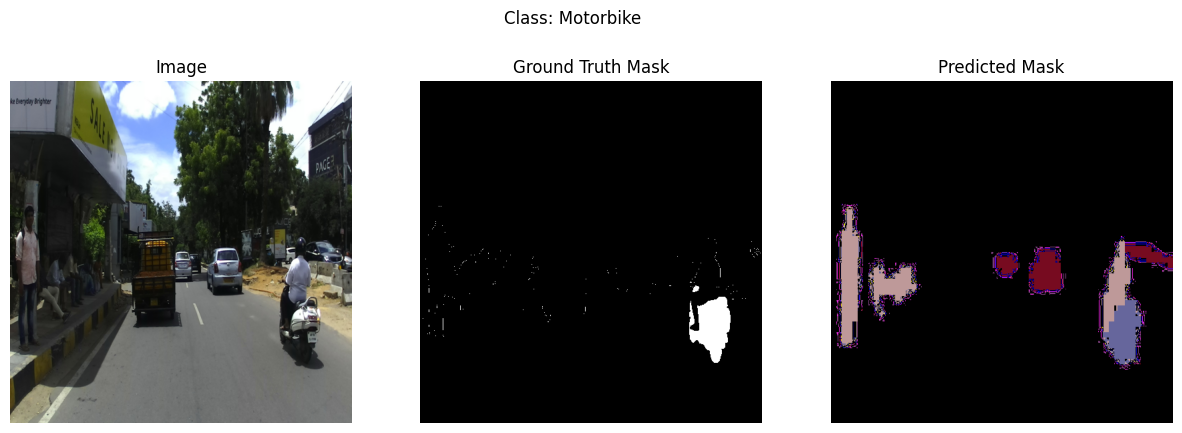

Visualizing images with IoU <= 0.5 for class: Bicycle


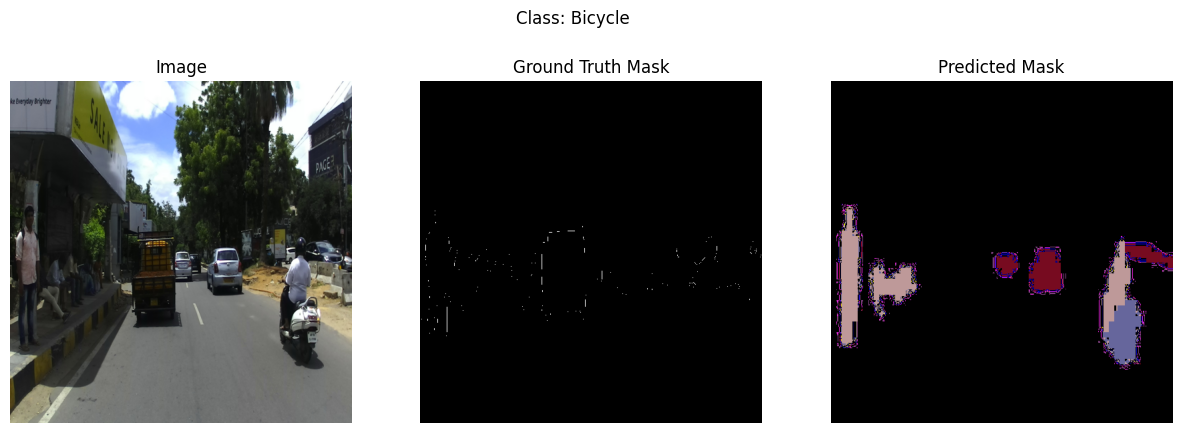

Visualizing images with IoU <= 0.5 for class: Car


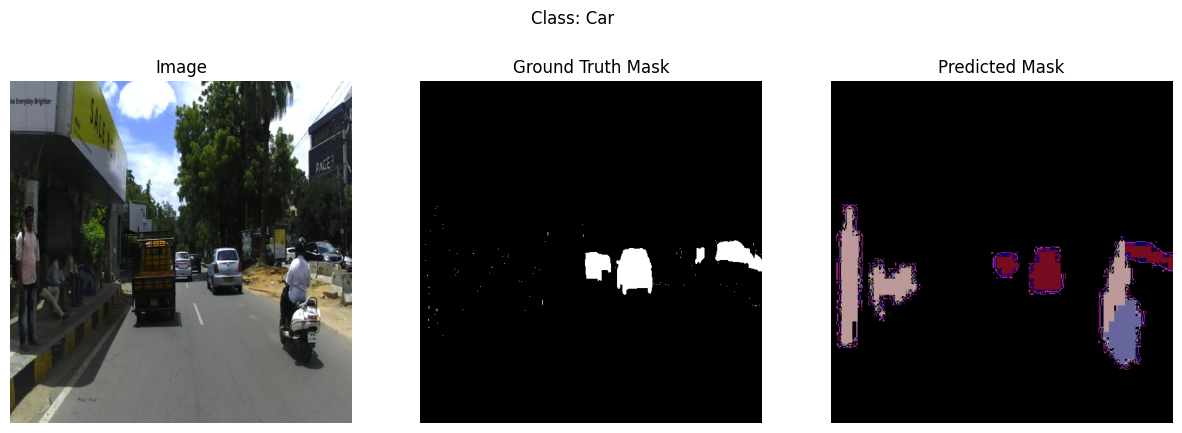

Visualizing images with IoU <= 0.5 for class: Truck


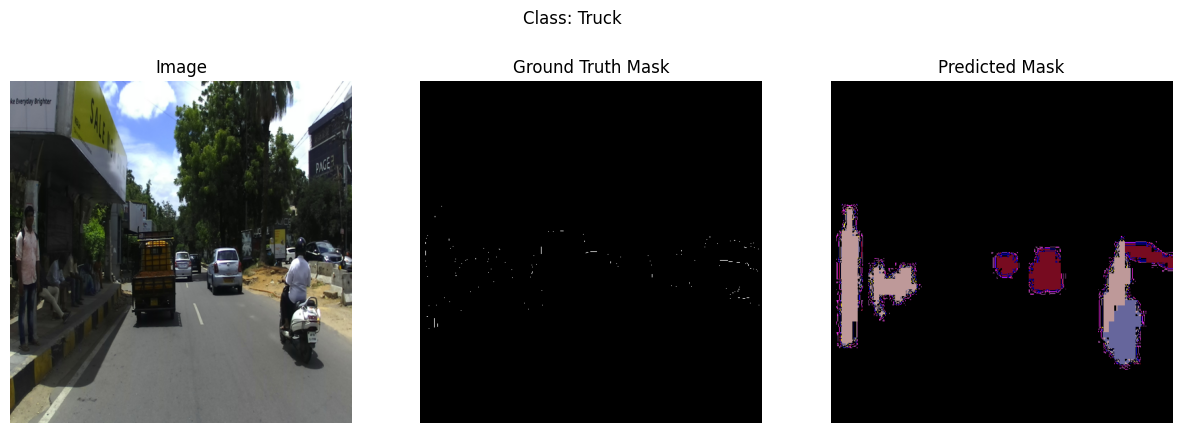

Visualizing images with IoU <= 0.5 for class: Bus


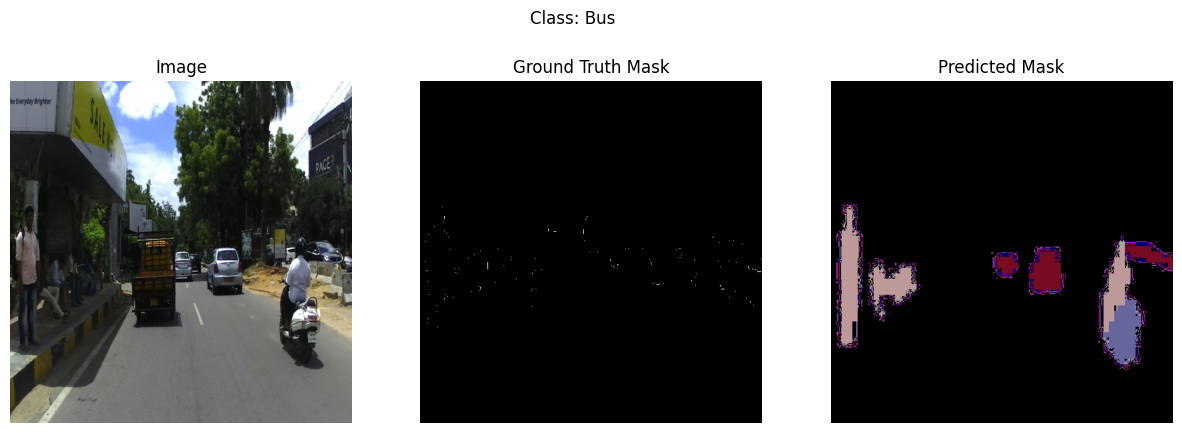

Visualizing images with IoU <= 0.5 for class: Train


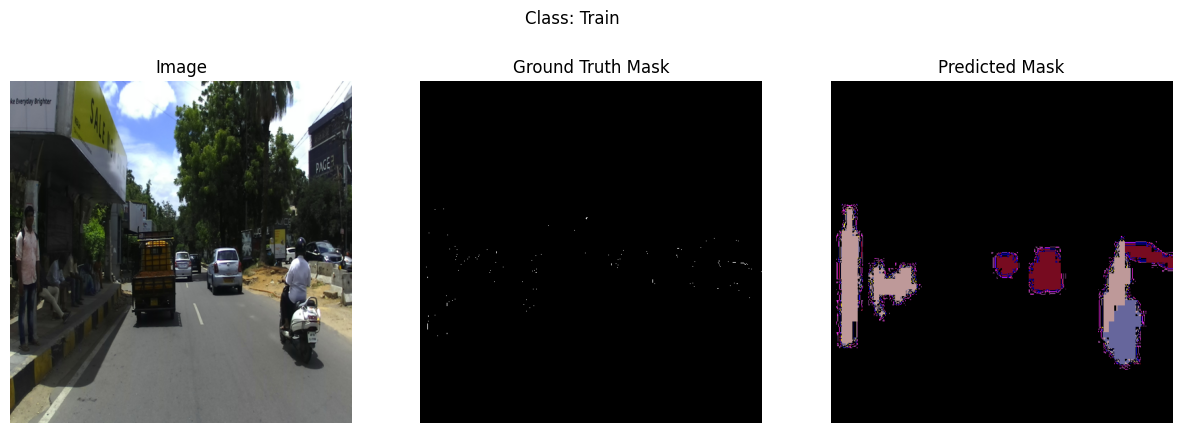

Visualizing images with IoU <= 0.5 for class: Wall


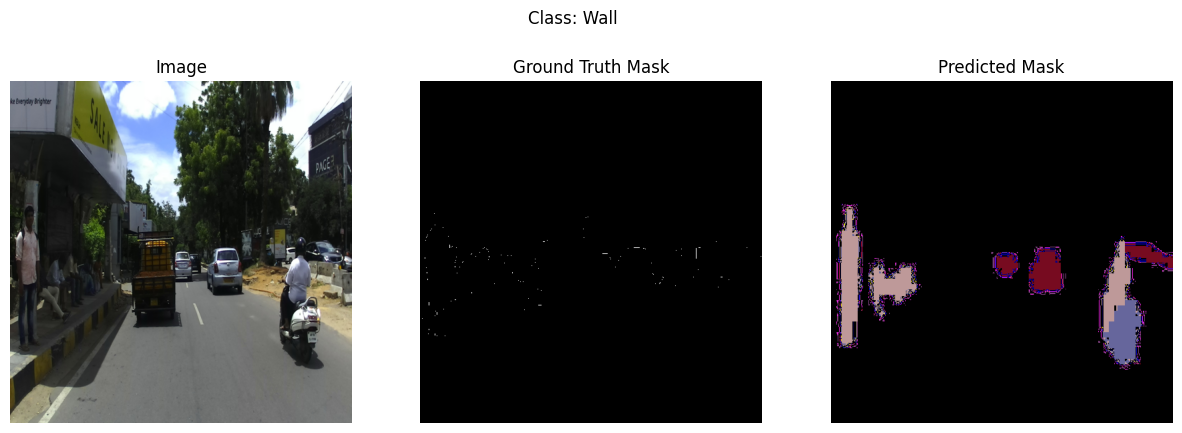

Visualizing images with IoU <= 0.5 for class: Fence


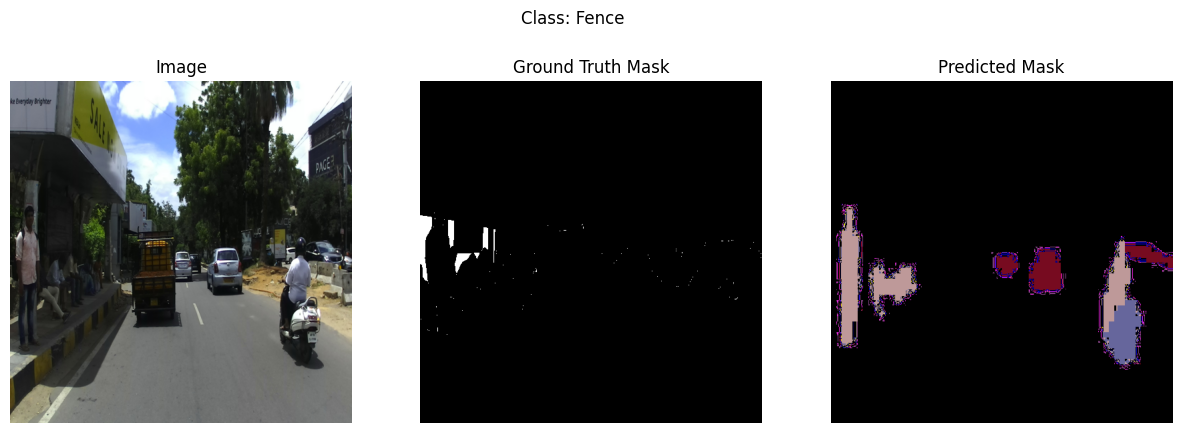

Visualizing images with IoU <= 0.5 for class: Traffic Sign


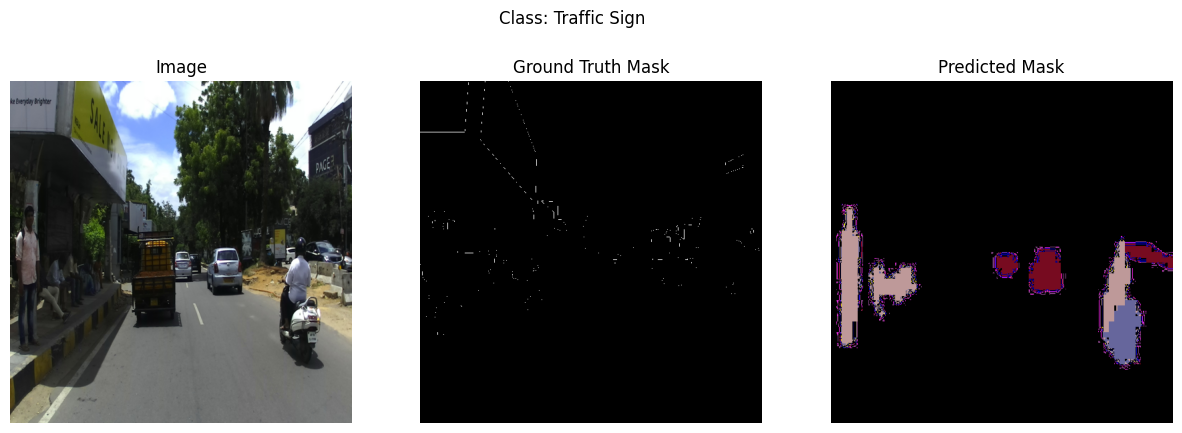

Visualizing images with IoU <= 0.5 for class: Traffic Light


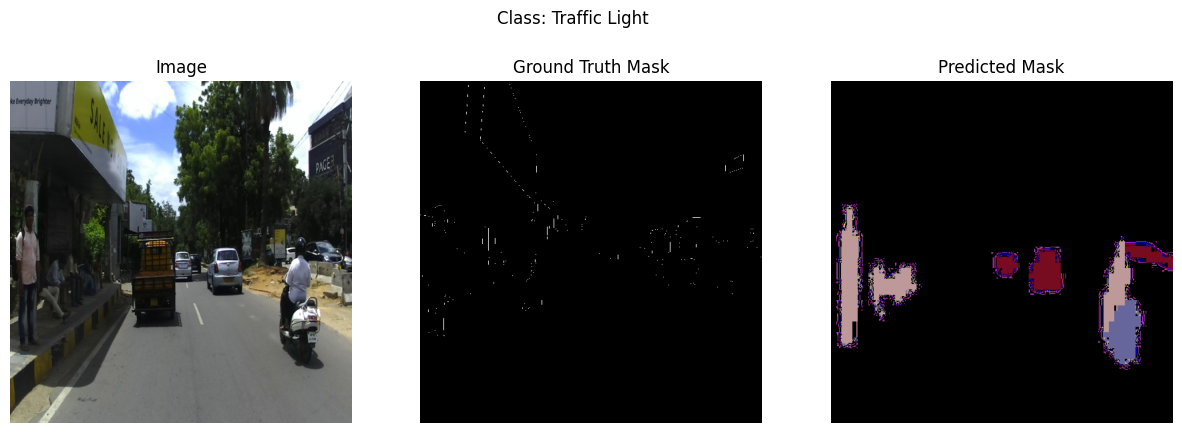

Visualizing images with IoU <= 0.5 for class: Pole


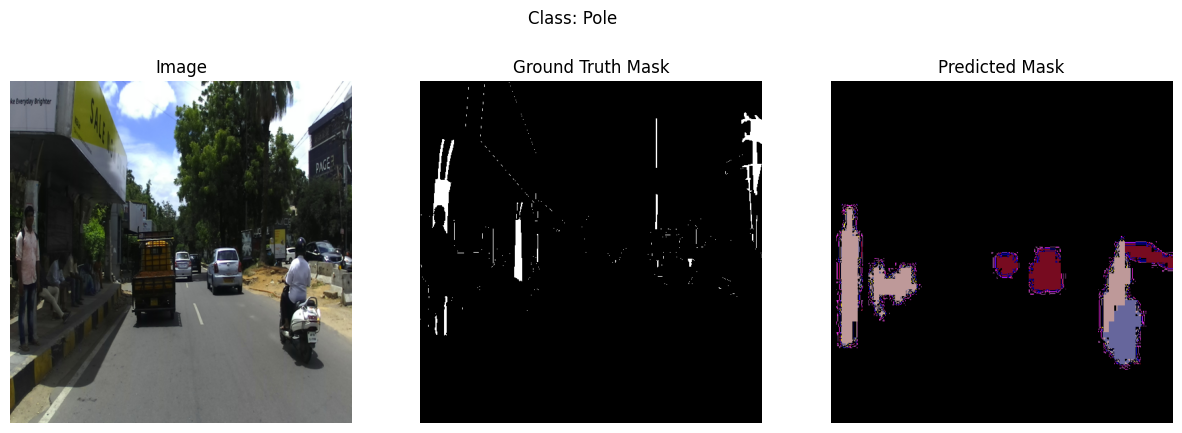

Visualizing images with IoU <= 0.5 for class: Building


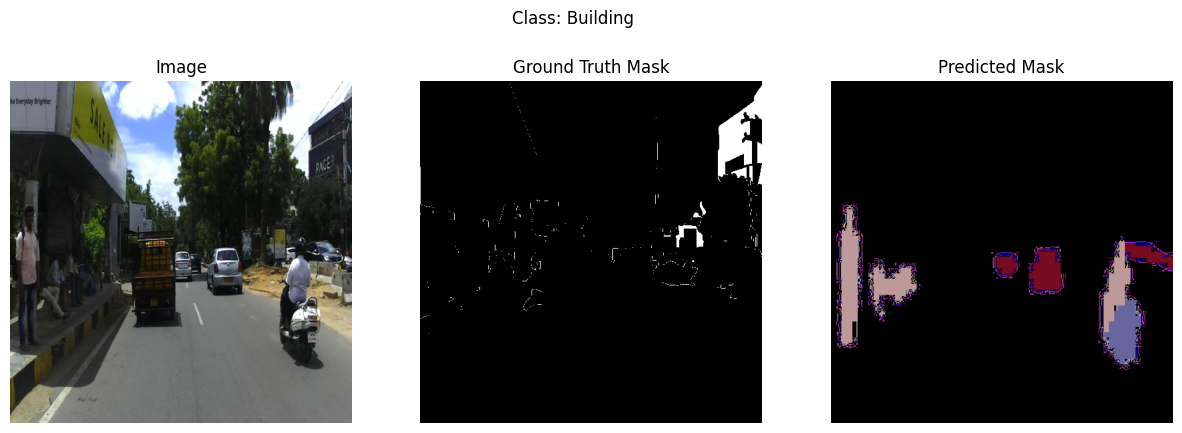

Visualizing images with IoU <= 0.5 for class: Vegetation


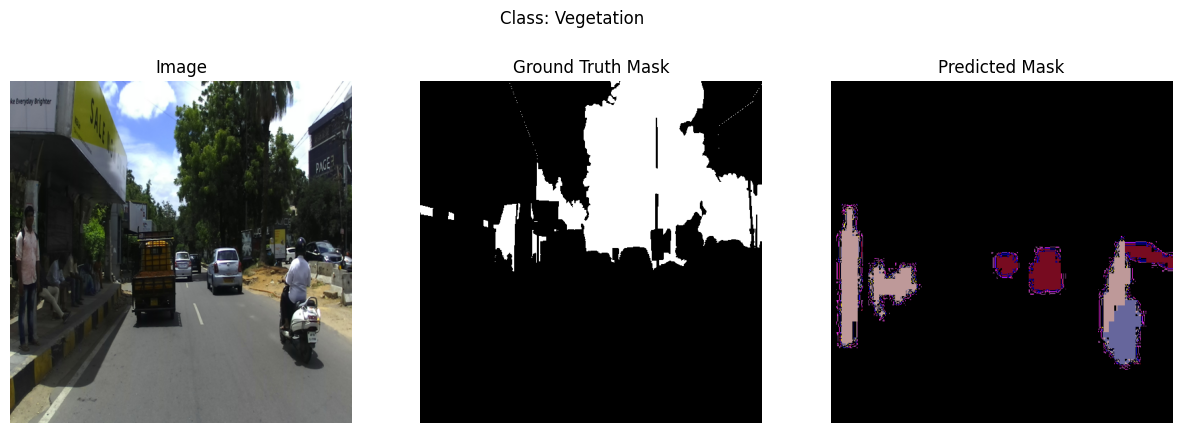

Visualizing images with IoU <= 0.5 for class: Sky


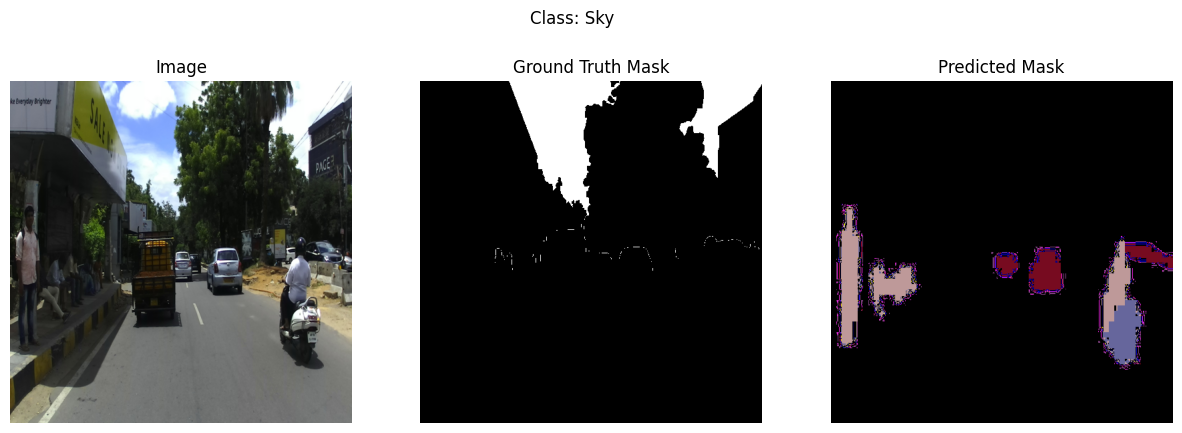

In [ ]:
class_colors = {
    1: [128, 64, 128],
    2: [244, 35, 232],
    4: [220, 20, 60],
    5: [0, 0, 230],
    6: [0, 0, 142],
    7: [119, 11, 32],
    9: [0, 0, 230],
    10: [0, 0, 70],
    11: [0, 0, 70],
    12: [0, 0, 70],
    14: [102, 102, 156],
    15: [190, 153, 153],
    18: [220, 220, 0],
    19: [250, 170, 30],
    20: [153, 153, 153],
    22: [70, 70, 70],
    24: [107, 142, 35],
    25: [70, 130, 180],
}
def visualize_masks(image, gt_mask, pred_mask, class_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(gt_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    colored_pred_mask = np.zeros_like(image)
    for class_id, color in class_colors.items():
        colored_pred_mask[pred_mask == class_id] = color
    axes[2].imshow(colored_pred_mask)
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.suptitle(f"Class: {class_name}")
    plt.show()

for class_name in relevant_classes:
    indices = np.where(IoU_by_class[class_name] <= 0.5)[0]
    if len(indices) == 0:
        print(f"No images with IoU <= 0.5 for class: {class_name}")
        continue

    print(f"Visualizing images with IoU <= 0.5 for class: {class_name}")
    count = 0
    for i in indices:
        image_name = image_paths[i]
        mask_name = mask_paths[i]

        image_path = os.path.join(images_dir, image_name)
        mask_path = os.path.join(masks_dir, mask_name)

        image = Image.open(image_path).convert("RGB").resize((512, 512))
        gt_mask = np.array(Image.open(mask_path).convert("L").resize((512, 512)))
        pred_mask = np.array(Image.open(os.path.join(output_dir, mask_name.split('.')[0] + '.jpg')).resize((512, 512)))

        if np.mean(gt_mask == cityscapes_class_ids[class_name]) == 0:
            continue

        visualize_masks(image, gt_mask == cityscapes_class_ids[class_name], pred_mask, class_name)
        count += 1
        if count == 3:
            break


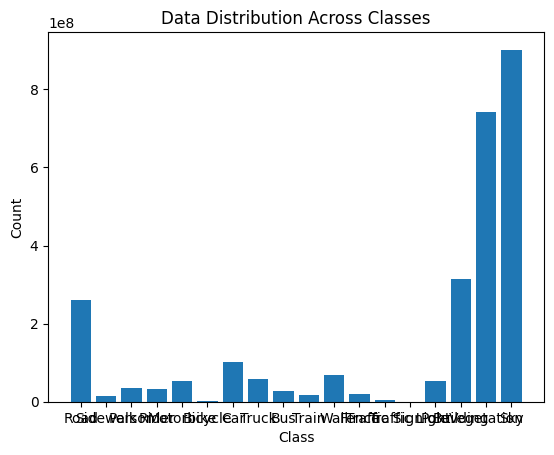

In [ ]:
import os
import  matplotlib.pyplot as plt
from PIL import Image
import numpy as np
cityscapes_class_ids = {
    'Road': 0+1, 'Sidewalk': 2, 'Person':4, 'Rider': 5, 'Motorbike':6, 'Bicycle': 7,
    'Car': 9, 'Truck': 10, 'Bus': 11, 'Train': 12, 'Wall': 14, 'Fence': 15,
    'Traffic Sign': 18, 'Traffic Light': 19, 'Pole': 20, 'Building': 22,
    'Vegetation': 24, 'Sky': 25
}
label_folder = "/content/drive/MyDrive/30_images_masks/masks"

class_counts = {}
for class_name in cityscapes_class_ids.keys():
    class_counts[class_name] = 0

for label_file in os.listdir(label_folder):
    label_path = os.path.join(label_folder, label_file)
    label = np.array(Image.open(label_path))

    for class_name, class_value in cityscapes_class_ids.items():
        class_counts[class_name] = class_counts[class_name]+np.sum(label == class_value)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Distribution Across Classes')
plt.show()